***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.2 Interative Deconvolution with Point Sources (CLEAN)](6_2_clean.ipynb)  
    * Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

/Users/denghui/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
HTML('../style/code_toggle.html')

***

## 6.3 CLEAN的实现  CLEAN Implementations<a id='deconv:sec:flavours'></a>

在前一节我们采用点源近似引入了迭代去卷积的概念，也被称为“CLEAN”，更准确地说，是在图像域实现“CLEAN”。经过多年的发展，随着计算能力的进步，已经出现了各种类型的“CLEAN”。到今天，针对特定的案例研究去卷积算法，实现更为先进的“CLEAN”已经成为了研究热点，本节后面会简要讨论到这些内容。这里，我们将首先讨论几种基本的“CLEAN”方法的实现和各自的优缺点，包括图像域、网格化可见度域以及可见度域。

In the previous section we introduced the concept of iterative deconvolution using a point-source approximation to the sky, also known as `CLEAN`. That example was more precisely an image-domain implementation of `CLEAN`. There are in fact multiple variants of `CLEAN` as it has been extended over the years to improve results, mainly due to advancements in computing power that have lead to more compute intensive operations being possible. Today there is an active field of developing more advanced `CLEAN` implementation and deconvolution algorithms which can solve special cases. These will be briefly discussed at the end of this section. We will first discuss the implementation and advantages/disadvantages of the basic variants of `CLEAN`: image-domain, gridded visibility-domain, and visibility-domain.

在前一节的最后面我们看到，通过去卷积我们生成了一张复原图，图中的大多数PSF的旁瓣结构已经被去除。

As a reminder from the previous section, after deconvolution we can produce a restored image which have most of the PSF sidelobe structure, seen in the dirty image, removed:

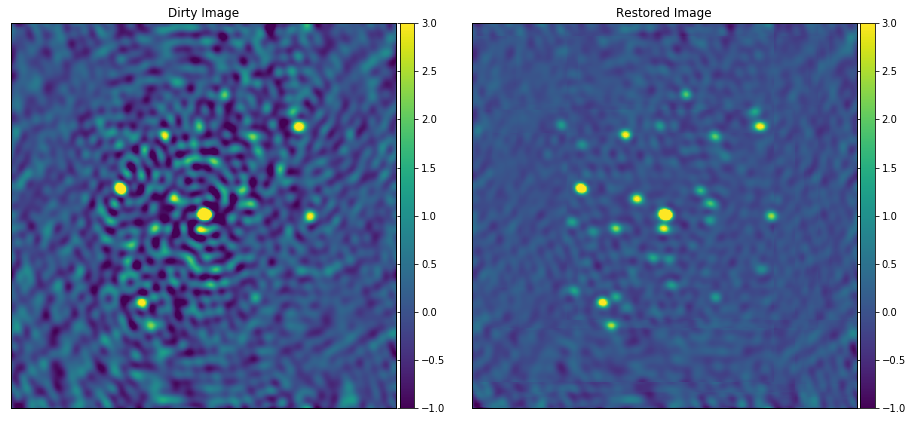

In [4]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits', \
                       figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n300-image.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
gc2.hide_axis_labels()
gc2.hide_tick_labels()
plt.title('Restored Image')
gc2.add_colorbar()

fig.canvas.draw()

图：KAT-7的脏图（左），CLEAN后的复原图（右）。

*Figure: restored image (right) after running CLEAN on the dirty image (left) from a KAT-7 observation.*

### 6.3.1 图像域(Högbom)    Image-domain (Högbom)

在1974年[<cite data-cite='1974A&AS...15..417H'>Högbom</cite> &#10548;](http://adsabs.harvard.edu/abs/1974A%26AS...15..417H)首次实现了“CLEAN”算法，见 [here &#10142;](hogbom_clean.ipynb)。其基本思路为，在预先知道PSF以及点源近似的情况下，以迭代的方式，从脏图中不断减去PSF与某些流量的乘积，从而移除点源，最终得到一个$\delta$函数的天空模型和一个减掉了噪声和源的残图。在图像域实现“CLEAN”的伪代码如下：

The first implementation of `CLEAN` was presented by [<cite data-cite='1974A&AS...15..417H'>Högbom</cite> &#10548;](http://adsabs.harvard.edu/abs/1974A%26AS...15..417H) in 1974. A notebook version of this method can be found [here &#10142;](hogbom_clean.ipynb). The basic concept is that the PSF of the observation is known, and source are point-like, so the PSF, multiplied by some flux value, can be iteratively subtracted from the image to remove these point sources. This results in a sky model of $\delta$-functions and a residual image of the noise and sky sources not removed. A pseudo-code implementation of image-domain `CLEAN` is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, I^{\textrm{res}} \leftarrow I^{D}, i \leftarrow 0$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:}$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$

$\qquad i \leftarrow i +1$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

输入为脏图和PSF（两者都是$l$和$m$的二维函数）、一个循环增益参数$\gamma$、一个流量阈值$f_{\textrm{thresh}}$ 或 迭代次数 $N$作为循环停止条件。

The inputs are the dirty image and the PSF, both of which are 2-d functions in $l$ and $m$, a loop gain parameter $\gamma$, a flux threshold $f_{\textrm{thresh}}$ or maximum number of iterations $N$ as stopping criteria.


#### 输入参数：循环增益$(\gamma)$    Input Parameter: Loop gain $(\gamma)$

参数$\gamma$用来控制每次迭代过程中要减掉的流量，取值范围为0到1。如果$\gamma=1$，则该像素上的所有流量将被全部减掉，残图里会产生空洞，而事实上，每个像素都或多或少含有噪声。如果$\gamma=0$，则减掉的流量为零，相当于没有去卷积。因此，$\gamma$的取值范围为0到1，一般设置为0.1，即每次迭代，从残图中减去10%的峰值流量。循环增益设置太高，将会过度去卷积，噪声被减掉从而导致图像产生“空洞”。循环增益设置太小，则循环次数太多，计算时间过长。

The $\gamma$ parameter ranges from 0 to 1, and controls the amount of flux subtracted with each iteration. If $\gamma=1$ then all the flux of a pixel is subtracted, this is not good as each pixel contains some amount of noise. If $\gamma=0$ then no flux is subtracted and no deconvolution occurs. Thus, $\gamma$ is set somewhere between 0 and 1, a typical value would be $0.1$, this means that each iteration 10% of the peak flux value is subtracted from the residual image. If the loop gain is too high then the deconvolution maybe over ambitious and subtract out noise from the image, leading to 'holes' in the image. If the loop gain is not large enough then the number of iterations required to complete a deconvolution will be prohibitively long.

#### 输入参数：循环停止条件$(N, f_{\textrm{thresh}})$   Input Parameter: Stopping criteria $(N, f_{\textrm{thresh}})$

可以设置两个循环终止条件，任一条件满足时停止循环。一个条件是迭代次数N，如果设置$N=100$，则迭代100次后，结束去卷积。这个参数的好处在于可以预估得到去卷积的时间。另一个条件是流量阈值$f_{\textrm{thresh}}$，当残图中剩下的最大流量值小于等于该阈值时，结束去卷积。使用阈值条件的优点在于可以预先知道残图里剩下的最大流量值。

There are two stopping criteria, only one of which is needed. The first is to set the maximum number of iterations, say $N=100$, then after 100 iteration deconvolution will stop. This has the advantage of setting a fixed computation time. The other criteria is to set a flux threshold $f_{\textrm{thresh}}$ such that when the maximum flux value remaining in the residual image is at or below this threshold deconvolution is stopped. This has the advantage of deconvolving down to a known flux level.


#### 初始化和输出 Initialization and Output

初始化过程包括把迭代次数置为0、制作脏图副本以及生成一个空的天空模型。在每次迭代过程中，残图中将被减去一些流量，天空模型里会增加一个$\delta$-function源，源的流量为残图里被减掉的流量。一旦达到结束条件，则输出天空模型和残图。

Deconvolution is initialized by setting the number of iterations to 0, making a copy of the dirty image called the residual image, and creating an empty sky model. During each iteration flux will be subtracted from the residual image and a $\delta$-function source is added to the sky model representing the flux subtracted from the residual image. Once the stopping criteria is met, the completed sky model and residual image is output.

#### 迭代循环  Iterative Loop

只要结束条件不满足，就会执行一次“CLEAN“迭代。首先找出残图中的最大流量$f_{\textrm{max}}$及所在的位置$(l_{\textrm{max}}, m_{\textrm{max}})$，然后$PSF\cdot\gamma \cdot f_{\textrm{max}}$，最后把$PSF\cdot\gamma \cdot f_{\textrm{max}}$的中心移动到残图中的峰值流量的像素位置，两者相减使残图的整体流量变小。

While the stopping criteria has not been met, a `CLEAN` iteration is done. The location $(l_{\textrm{max}}, m_{\textrm{max}})$ of the pixel with the maximum flux $f_{\textrm{max}}$ in the image is found. The PSF is offset to be centred on the peak flux pixel and multiplied by the flux value and gain loop, this is then subtracted from the residual image. The overall flux of the residual image has been reduced.

$$I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \gamma \cdot f_{\textrm{max}} \cdot \textrm{PSF}(l+l_{\textrm{max}}, m+m_{\textrm{max}})$$

接下来，在天空模型里增加一个$\delta$-function的源，源的位置为$(l_{\textrm{max}}, m_{\textrm{max}})$，流量为$\gamma \cdot f_{\textrm{max}}$。

Then a $\delta$-function with flux $\gamma \cdot f_{\textrm{max}}$ source is added to the sky model in the position of the maximum flux.

$$S^{\textrm{model}} \leftarrow S^{\textrm{model}} + \{l_{\textrm{max}}, m_{\textrm{max}}: \gamma \cdot f_{\textrm{max}}\}$$



The new flux at ($l_{\textrm{max}}, m_{\textrm{max}}$) in the sky model is added to any flux in that position from a previous iteration.

以上是一个最简单的“CLEAN”实现，但同时有其局限性。首先是残图和PSF的像素量固定，而当从残图中减掉PSF时，需要移动PSF，如此一来，残图中只有部分像素的流量被减掉。有两个办法来解决这一问题，第一是把PSF扩大到至少两倍的图像大小，算上两个方向的话则PSF的总像素量至少扩大到了4倍；第二是只对残图的中央部分去卷积。然后是天空模型受到残图中的像素分辨率的影响，而真实的源并不总是正好位于一个像素的中心，这就会产生伪影。为了解决上述问题，出现了新一代的“CLEAN”。

This is the simplest implementation of `CLEAN` but is also limited as one would expect from being the original `CLEAN` method. The first issue is that the residual image and PSF are images with a fixed number of pixels. When subtracting flux from the residual image the PSF is offset, thus flux from only a subset of the residual image is subtracted. This requires either computing a PSF image at least twice as large (in both directions for 4 times the number of pixels), or limiting deconvolution to the centre of the residual image. The second issue is that the sky model is fixed to the resolution of the pixels in the residual image, this leads to artefacts as sources are never perfectly at the centre of a pixel. Accounting for these issues lead to the next developments in `CLEAN`.

### 6.3.2 网格化可见度域（Clark）Gridded Visibility-domain (Clark)

1980年，Clark在Högbom方法的基础上，提出了一种去卷积的新方法[<cite data-cite='1980A&A....89..377C'>Clark</cite> &#10548;](http://adsabs.harvard.edu/abs/1980A%26A....89..377C) 。该方法首先在图像域进行部分的Högbom去卷积得到部分天空模型，然后利用快速傅立叶变换在可见度域对这一批天空模型做“批量“的去卷积处理，在[exercise &#10142;](clark_clean_assignment.ipynb)有这种方法的实现代码。Clark方法的基本思路为首先通过次循环“minor cycle”在图像域里找到一组亮的像素（根据PSF旁瓣设置阈值）组成一个部分天空模型，然后在主循环里从残图中减掉该天空模型与PSF的卷积。根据傅立叶变换和卷积理论，对次循环里得到的部分天空模型和PSF做傅立叶变换，然后在可见度域对变换结果相乘，再做逆傅立叶变换回到图像域，最后从残图中减掉从而得到新的残图。这种方法比Högbom快，而且能对图像中更宽的范围做去卷积处理。其伪代码如下：

In 1980 [<cite data-cite='1980A&A....89..377C'>Clark</cite> &#10548;](http://adsabs.harvard.edu/abs/1980A%26A....89..377C) introduced a variant on Högbom's method which took advantage of fast Fourier transforms to do a form of 'batch' deconvolution in the the visibility domain after running a partial Högbom deconvolution in the image domain. An implementation of this method is left as an [exercise &#10142;](clark_clean_assignment.ipynb), a starting point notebook with helper functions is provided. The general structure of his method was to search for a set of bright pixels in the image domain (above some threshold based on the PSF sidelobes), build a partial sky model in the 'minor' cycle. The partial sky model needs to be convolved with the PSF before being subtracted from the residual image. Using the Fourier transform and convolution theorem the the sky model and PSF can be Fourier transformed and multiplied together in the visibility domain, inverse Fourier transformed back to the image domain and subtracted from the previous residual image to produce an updated residual image. This has the advantage of potentially being faster than Högbom's method, and allows for deconvolution over a larger portion of the image. This implementation in pseudo-code is:

$\textbf{input: } I^{D}(l,m), \ \textrm{PSF}(l,m), \ \gamma, \ f_{\textrm{thresh}}, \ N$

$\textbf{initialize: } S^{\textrm{model}} \leftarrow \{\}, \ I^{\textrm{res}} \leftarrow I^{D}, \ i \leftarrow 0, \ (\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}}) \leftarrow g(\textrm{PSF}(l,m))$

$\textbf{while} \ \textrm{any}(I^{\textrm{res}} > f_{\textrm{thresh}}) \ \textrm{or} \ i \leq N \ \textbf{do:} \quad [\textrm{Major Cycle}]$

$\qquad l_{\textrm{max}}, m_{\textrm{max}} \leftarrow \underset{l,m}{\operatorname{argmax}} I^{\textrm{res}}(l,m)$

$\qquad f_{\textrm{max}} \leftarrow I^{D}(l_{\textrm{max}}, m_{\textrm{max}})$

$\qquad S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}}) \quad [\textrm{Minor Cycle}]$

$\qquad V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\}, V^S \leftarrow \mathscr{F}\{\textrm{PSF}\}$

$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \mathscr{F}^{-1}\{V^S \cdot V^{\textrm{model}}_{\textrm{partial}}\}$

$\qquad S^{\textrm{model}} \leftarrow S^{\textrm{model}} + S^{\textrm{model}}_{\textrm{partial}}$

$\qquad i \leftarrow i +1$

$\textbf{ouput: } S^{\textrm{model}}, I^{\textrm{res}}$

输入数据和参数跟图像域的“CLEAN”一样，因此，在主循环中使用跟次循环一样的Högbom方法。

The input data and parameters are the same as those for the image-domain `CLEAN`. And, uses Högbom's method as the minor cycle within the major cycle.

#### 初始化 Initialization

初始化时多了一个确定子PSF的过程，在次循环的图像域“CLEAN”时要用到该子PSF。

The initialization has an extra step which selects a subset of the PSF to use in the the minor cycle image-domain `CLEAN`.

$$\textrm{PSF}_{\textrm{sub}}(l,m), \ R_{\textrm{PSF}} \leftarrow g(\textrm{PSF}(l,m))$$

用来确定子PSF的函数$g$没有统一的定义，完全取决于具体的算法实现，但在实际操作中，一般会选择PSF的核心区域到最高旁瓣（除了一些高度冗余的阵列，通常是一级旁瓣）范围。该函数还会返回一个最高旁瓣与主瓣的比值，这个值会小于1。确定子函数的依据在于PSF的能量主要集中在该区域，而图像里任何一个高于一级旁瓣的像素里都包含有一个源。需要做出权衡的是，子PSF取得越小，则能去卷积的图像范围越大，但出错概率也越高；子PSF越宽，则能去卷积的图像区域越小，但出错的概率也越低。

The function $g$ which selects this subset is not well defined, and depends on exact implementation of the algorithm. But, generally the subset of the PSF is taken to be the central region of the PSF out to the highest sidelobes (usually the first sidelobes, except in highly redundant arrays). The function also returns the ratio $R_{\textrm{PSF}}$ of the the highest PSF sidelobe to the PSF main lobe, this will be less than 1. The justification for truncating the PSF is that the majority of the power in the PSF is contained within this region. And, any pixel in the image which is higher than the first sidelobe (as a fraction of the peak pixel flux) contains a source. The trade-off in the size of the PSF subset is that the smaller it is the more of the image can be deconvolved, but at the cost of increased errors. The larger the PSF subset the smaller the image region which can be deconvolved, but the less error-prone the deconvolution.

#### 次循环 Minor Cycle

在次循环里，根据最新的残图和子PSF在图像域去卷积，从而构建出部分天空模型。

The minor cycle is a partial sky model construction using image-domain deconvolution of the current residual image using the subset of the PSF.

$$S^{\textrm{model}}_{\textrm{partial}} \leftarrow \textrm{Hogbom}(I^{\textrm{res}}, \  \textrm{PSF}_{\textrm{sub}}, \ \gamma, \ f_{\textrm{max}} \cdot R_{\textrm{PSF}})$$

可以根据PSF旁瓣与主瓣的比值$R_{\textrm{PSF}}$设置次循环的结束阈值，即$f_{\textrm{max}} \cdot R_{\textrm{PSF}}$。比值设得越大，则次循环里的卷积去的越深。因为此时我们并不关心残图，所以没有输出残图。

The stopping criteria threshold is set to a precentage of the maximum flux based on the PSF sidelobe to main lobe ratio $f_{\textrm{max}} \cdot R_{\textrm{PSF}}$. The larger this ratio the deeper the deconvolution can be done in the minor cycle. As we do not care about the residual image at this point, we ignore this output of Högbom's method.

#### 主循环 Major Cycle

跟Högbom方法一样，主循环也是要先找出残图中的最大流量跟对相应位置，然后再用一个较高的流量阈值调用Högbom，对残图中流量最大的那些像素值做比较浅层的去卷积。在次循环里采用子PSF能对较大区域的残图去卷积，并返回一个部分天空模型。

The major cycle starts as does by finding the maximum flux and position, similar to Högbom's method. A call is then made to Högbom's method using a high flux threshold value, this works as a shallow deconvolution on the pixels with the most flux. The subet of the PSF is used in the minor cycle, this allows for deconvolution across a larger region of the image. From this a partial sky model is returned.

利用FFT算法把部分天空模型和完整PSF从图像域转换到可见度域，得到部分天空模型的可见度$V^{\textrm{model}}_{\textrm{partial}}$以及阵列的采样函数$V^S$。

Using the computational efficiency of FFT algorithms the partial sky model and full PSF is Fourier transformed to the visibility domain. This produces an ideal sky model visibility $V^{\textrm{model}}_{\textrm{partial}}$, the array sampling function $V^S$.

$$V^{\textrm{model}}_{\textrm{partial}} \leftarrow \mathscr{F}\{S^{\textrm{model}}_{\textrm{partial}}\} \\ V^S \leftarrow \mathscr{F}\{\textrm{PSF}\}$$

天空模型的可见度乘上采样函数（相当于图像域中的PSF卷积天空模型），再通过逆傅立叶变换回到图像域，然后从残图中减去逆傅立叶变换的结果。

The sky model visibilities are multiplied by the sampling function (this is the compute intensive convolution of the PSF and sky model in the image-domain), inverse Fourier transformed and subtracted from the residual image.

$$\qquad I^{\textrm{res}} \leftarrow I^{\textrm{res}} - \mathscr{F}^{-1}\{V^S \cdot V^{\textrm{model}}_{\textrm{partial}}\}$$

最后把次循环所得到的部分天空模型加到完整天空模型中。

The full sky model is updated by adding in the sky model components for the minor cycle.

Clark方法通过FFT，把部分天空模型与PSF之间的卷积变成了乘积，从而加速了去卷积过程。通过采用子PSF来构建图像域的天空模型，使得我们能对更宽的图像区域做去卷积处理，同时与在图像域里用子PSF去卷积相比，在主循环中通过完整PSF从残图中批量减掉天空模型的效果更好，速度也更快。Clark方法的局限性在于，网格化会引入网格化效应与混叠效应。

Clark's method of `CLEAN` deconvolution takes advantage of FFT algorithms to speed up the convolution of a partial sky model with the PSF. Using a subset of the PSF to build the image-domain sky model allows for a larger region of the image to be deconvolved, while doing the batch subtraction in the major cycle with the full PSF results in a better (and sometimes faster) deconvolution compared to just doing an image-domain deconvolution with the PSF subset. The limitations are that because the source subtraction is done on gridded visibilities this can result in errors due to the gridding and aliasing effects.

### 6.3.3 可见度域(Cotton-Schwab) Visibility-domain (Cotton-Schwab)

早先受制于有限的计算和内存资源，必须对去卷积方法进行细致的优化和近似处理。随着计算和内存资源变得越来越便宜，不断研制出了更先进的去卷积方法，这些方法是当前的研究热点，但是已经超出了本课程的范围，请参考[references &#10142;](6_x_further_reading_and_references.ipynb)。

`CLEAN` methods were first implemented in a time of limited computing and memory resources. Careful consideration was required in optimizing these deconvolution methods with in these constraints. This led to good approximate solutions to deconvolution. As computing power and memory has become cheaper more advanced deconvolution methods are continuously in development. These methods are beyond the scope of the course, but are part of an active field of research. See the end of this chapter for [references &#10142;](6_x_further_reading_and_references.ipynb) to current work.

继Clark以后，对Clean的下一次重大改进发生在1984年，Cotton-Schwab在Clark方法的基础上对非网格化的可见度做去卷积处理 [<cite data-cite='1984AJ.....89.1076S'>Schwab</cite> &#10548;](http://adsabs.harvard.edu/abs/1984AJ.....89.1076S)。非网格化的可见度，指的是没有经过网格化处理（见[$\S$ 5.3](../5_Imaging/5_3_gridding_and_degridding.ipynb)）的、直接观测所得到的可见度。Cotton-Schwab对整个图像去卷积从而避免引入PSF伪影混叠，但是需要更高的计算能力和内存空间。时至今日，Cotton-Schwab方法依然应用广泛，是大多数后续的CLEAN实现的基础。

After Clark's method the next major advancement was in 1984, [<cite data-cite='1984AJ.....89.1076S'>Schwab</cite> &#10548;](http://adsabs.harvard.edu/abs/1984AJ.....89.1076S) introduced a modifcation on Clark's method which performs the deconvolution on the ungridded visibilities. Just to be clear, the ungridded visibilities are the visibilities produced during an observation, before they are gridded onto a 2-D plane as descirbed in [$\S$ 5.3](../5_Imaging/5_3_gridding_and_degridding.ipynb). The Cotton-Schwab method allows for deconvolution across the entire image and does not introduce PSF artefact aliasing at the cost of an increase in computation and memory usage. The Cotton-Schwab method is still widely used today and is the basis for most subsequent `CLEAN` implementation.

”Clean“泛指所有迭代扣除天空模型的去卷积方法，类似地，Cotton-Schwab也有多种不同的具体实现，因此很难给出一个统一的伪代码实现。Cotton-Schwab采用了跟Clark一样的主/次循环结构，但在主循环中没有采用网格化的可见度天空模型去除，而是计算非网格化的天空模型。有两种生成非网格化天空模型可见度的方法：

1. 如果天空模型中源的数量有限，可以对每个源做直接傅立叶变换，然后计算出每个uv采样的准确的可见度。
2. 如果天空模型中源的数量很多（通常情况），则可以跟Clark一样，把天空模型转换成网格化的可见度，然后用在[de-gridder &#10142;](../5_Imaging/5_3_gridding_and_degridding.ipynb)介绍的方法做近似处理，从而得到非网格化的可见度。

Just as `CLEAN` is a general term for deconvolution using an iterative sky model subtraction process, the Cotton-Schwab method can vary based on implementation and which additional features are included. As such, it is not possible to write an easy pseudo-code implementation in the abstract. But, at a high level the Cotton-Schwab method follows Clark's major/minor cycle model. But, instead of subtracting the gridded visibilities from the sky model in the major cycle, a method is used to compute the ungridded visibilities for the sky model. There are two methods to generate ungridded visibilities from the sky model:

1. If there are only a few sources in the sky model a direct Fourier transform can be used on each source to compute the exact visibilities for each *uv* sample.
2. When there are many sources in the sky model, as is usually the case, the sky model is transformed to gridded visibilities as in Clark's methods then a [de-gridder &#10142;](../5_Imaging/5_3_gridding_and_degridding.ipynb) is used to make a close approximation to the ungridded visibilities.

上述基于天空模型的可见度常常被叫做“模型可见度”，可以用于自校准（见[$\S$8.3](../8_Calibration/8_2_1GC.ipynb)）。从观测可见度里减去模型可见度得到“残可见度”，对残可见度做逆傅立叶变换得到残图，然后继续下一轮的迭代去卷积过程。

These visibilities based on the sky model, often called *model visibilities*, can be used in the 'self-cal cycle', which is discussed in [$\S$8.3](../8_Calibration/8_2_1GC.ipynb). The model visibilities are subtracted from the observed visibilities resulting in *residual visibilities*. The residual visibilities are then imaged to produce a new residual image and the next iteration of deconovlution can proceed.

跟Högbom 和 Clark方法相比，Cotton-Schwab方法具有以下优势：

* 因为是对整图去卷积，所以不会引入PSF混叠效应。
* 可以单独对局部感兴趣的区域进行去卷积处理，从而实现对天空模型的精细控制。
* 当从天空模型生成残图时，可以考虑w项，从而得到更精确的天空模型，同时残图里的伪影也更少。

Deconvolving with the ungridded visibilities has a number of other advantages to Högbom and Clark's methods:

* There are no PSF aliasing effects because the deconvolution is independent of image size.
* Spatial regions of interest can be separately deconvolved or ignored, allowing for fine control over the sky modelling process.
* The w-term can be accounted for when producing the residual image from the sky model resulting in a more accurate sky model and fewer artefacts in the residual image.

显然，Cotton-Schwab方法以及在它的基础上派生出来的一系列方法具有很多优势，是目前CLEAN去卷积方法的标准。值得注意的是，当讨论到计算和内存资源的消耗时，网格/去网格过程都占据了绝对份额。在研究新的去卷积算法的同时，也要开发出高效率的算法实现。Högbom 和 Clark方法仍然在一些简单场景里使用，这非常有助于我们对当前热点的更为复杂的CLEAN的理解。

At this point it should be clear that the Cotton-Schwab method (and all its derivative methods) has many advantages over the methods discussed previously in this section, and is the standard `CLEAN` deconvolution method today. It is important to note here that when the discussion of computing limits in deconvolution the gridding/de-gridding process dominates the computational operations and memory budget over all other steps. Complementary to the development of new deconvolution algorithms is the topic of efficient implementation of well developed methods. Högbom and Clark's methods are still used in some cases, such as in simple fields, and are useful to understand as there is a progression from their simplicity to the more complex modern forms of `CLEAN` used today.

### 6.3.4 理想PSF和复原图像 The Idealized PSF and Restored Image

去卷积的时候往往还会生成一张复原图，这是一张比较漂亮的，经常被用来展示的图。复原图并不会提供比天空模型和残图更多的信息，只是比较好看。下面是一个复原图的例子。

Often a restored image is produced as a result of deconvolution. This is the 'pretty' image which people like to show in presentations. The restored image provides no additional information beyond that of the sky model and the residual image, but is a useful visualization tool. An example restored image is show below.

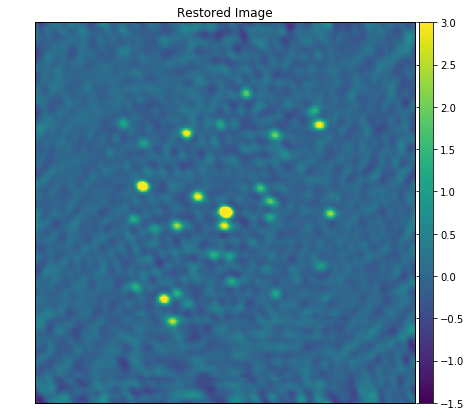

In [3]:
fig = plt.figure(figsize=(8, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n300-image.fits', \
                       figure=fig)
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
gc1.hide_axis_labels()
gc1.hide_tick_labels()
plt.title('Restored Image')
gc1.add_colorbar()

fig.canvas.draw()

图：KAT-7观测的CLEAN去卷积复原图。

*Figure: Restored image of a KAT-7 observation resulting from CLEAN deconvolution.*

天空模型与“理想PSF”或”理想束“卷积，再加上残图得到复原图。

The restored image is generated by convolving the sky model with an *ideal PSF* (or *ideal beam*) and adding in the residuals.

$$I_{\textrm{restored}} = I_{\textrm{skymodel}} \circ \textrm{PSF}_{\textrm{ideal}} + I_{\textrm{residual}}$$

此处的$I_{\textrm{skymodel}}$是天空模型的一个$\delta$-function图。定义理想PSF的方法虽然有多种，但基本上都是基于一个“理想”干涉测量阵列“的响应。一个理想的干涉测量阵列对整个空间进行采样，因此得到的是一个圆形的采样函数和带有旁瓣的艾里斑的PSF，见[$\S$ 5.2](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb)。更为理想的情况是用锥函数来生成一个平滑连续的采样函数，从而得到一个平滑且没有旁瓣的PSF，比如高斯函数。我们常常用一个2-D高斯来对实际的PSF的主瓣进行拟合，因为高斯函数比较易于拟合PSF的主瓣，同时由于没有引入旁瓣，所以能保证图像的分辨率。也可以选择其它的理想PSF，比如只保留原始观测PSF的主瓣，但是最常用的还是高斯PSF。在具体实现的时候，高斯函数的大小可以调整，最典型的做法是用一个旋转的2-D高斯函数对PSF的主瓣做拟合，另外一种做法是首先计算出PSF的半高全宽，然后根据该半高全宽构造出一个2-D高斯函数。

Where $I_{\textrm{skymodel}}$ is a $\delta$-function image of the sky model. The ideal PSF can be defined in a number of ways, but basically it is the response of an 'ideal' interferometric array. An ideal interferometric array samples all spatial modes out to the maximum baseline of the array. This would lead to a circular sampling function and airy disc PSF which, as we have seen in [$\S$ 5.2](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb) has sidelobes. A more ideal array would have a taper to make a smooth, continuous sampling function to lead to a smooth, sidelobe-free PSF, such as a Gaussian. A 2-D Gaussian, fit to the main lobe of the observation PSF, is often taken as the ideal PSF. The Gaussian function has the advantage of being easy to fit to the PSF main lobe and maintains the resolution of the image without introducing sidelobes. Other ideal PSF can be chosen, such as just selecting the main lobe of the observation PSF, but a Gaussian ideal PSF is standard in most imagers. This size scale can vary by implementation but a typical method is to fit a rotated 2-D Gaussian function to the main lobe of the PSF. Another method is to compute the full-width at half maximum of the PSF and then construct a 2-D Gaussian with the same full-width at half maximum.

在对图像进行去卷积处理时，通常会计算出理想PSF并输出到FITS头里，下面的代码展示了如何从FITS提取出理想PSF。

When a decolvolution is performed on an image the ideal PSF size is usually computed and as part of the standard output, and put in the FITS file header. Code in the $\S$ 6.3.5 shows how to extract the ideal PSF from the header.

### 6.3.5 KAT-7观测去卷积  Deconvolution of a KAT-7 Observation

讨论完各种`CLEAN`算法的实现以后，我们再来看看迭代的去卷积效果。采用前一章的KAT-7观测和Cotton-Schwab的“CLEAN”去卷积方法。

After this discussion of the various `CLEAN` implementations from an algorithmic point of view it is worthwhile to see how deconvolution looks visually as progressive iterations are performed. Using the KAT-7 observation from the previous chapter, we will step through deconvolution using the Cotton-Schwab `CLEAN` method.

In [14]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

def genRstoredBeamImg(fitsImg):
    """Generate an image of the restored PSF beam based on the FITS header and image size"""
    fh = fits.open(fitsImg)
    
    #get the restoring beam information from the FITS header
    bmin = fh[0].header['BMIN'] #restored beam minor axis (deg)
    bmaj = fh[0].header['BMAJ'] #restored beam major axis (deg)
    bpa = fh[0].header['BPA'] #restored beam angle (deg)
    dRA = fh[0].header['CDELT1'] #pixel size in RA direction (deg)
    ra0 = fh[0].header['CRPIX1'] #centre RA pixel
    dDec = fh[0].header['CDELT2'] #pixel size in Dec direction (deg)
    dec0 = fh[0].header['CRPIX2'] #centre Dec pixel

    #construct 2-D ellipitcal Gaussian function
    gFunc = generalGauss2d(0., 0., bmin/2., bmaj/2., theta=bpa)

    #produce an restored PSF beam image
    imgSize = 2.*(ra0-1) #assumes a square image
    xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies
    xpos -= ra0 #recentre
    ypos -= dec0 #recentre
    xpos *= dRA #convert pixel number to degrees
    ypos *= dDec #convert pixel number to degrees
    return gFunc(xpos, ypos) #restored PSF beam image
    
def convolveBeamSky(beamImg, skyModel):
    """Convolve a beam (PSF or restored) image with a sky model image, images must be the same shape"""
    sampFunc = np.fft.fft2(beamImg) #sampling function
    skyModelVis = np.fft.fft2(skyModel[0,0]) #sky model visibilities
    sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
    return np.abs(np.fft.fftshift(np.fft.ifft2(sampModelVis))) #sky model convolved with restored beam
    
def plotDeconvModelResidual(niter):
    """Specialized function to plot the results of a deconvolution run,
    convolves the sky model with the restoring beam for visual effect"""
    fig = plt.figure(figsize=(16, 7))
    
    if niter > 0:
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-residual.fits'%niter)
        residualImg = fh[0].data
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-model.fits'%niter)
        skyModel = fh[0].data
    
        #generate a retored PSF beam image
        restBeam = genRstoredBeamImg(
            '../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-residual.fits'%niter)
    
        #convolve restored beam image with skymodel
        convImg = convolveBeamSky(restBeam, skyModel)

    else: #special case: niter==0
        fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-image.fits'%niter)
        residualImg = fh[0].data
        convImg = np.zeros_like(residualImg)
    
    gc1 = aplpy.FITSFigure(residualImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
    gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
    gc1.hide_axis_labels()
    gc1.hide_tick_labels()
    plt.title('Residual Image (niter=%i)'%niter)
    gc1.add_colorbar()
    
    gc2 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    gc2.show_colorscale(vmin=0., vmax=2.5, cmap='viridis')
    gc2.hide_axis_labels()
    gc2.hide_tick_labels()
    plt.title('Sky Model')
    gc2.add_colorbar()
    
    fig.canvas.draw()

def plotDeconvRestored(niter):
    """Specialized function to plot the results of a deconvolution run,
    shows restored image and Fourier transform"""
    fig = plt.figure(figsize=(16, 7))
    
    fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n%i-image.fits'%niter)
    restoredImg = fh[0].data
    visSamples = np.abs(np.fft.fftshift(np.fft.fft2(restoredImg)))
    vsShape = visSamples.shape
    
    gc1 = aplpy.FITSFigure(restoredImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
    gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
    gc1.hide_axis_labels()
    gc1.hide_tick_labels()
    plt.title('Restored Image (niter=%i)'%niter)
    gc1.add_colorbar()
    
    gc2 = aplpy.FITSFigure(visSamples, figure=fig, subplot=[0.5,0.1,0.35,0.8])
    gc2.recenter(float(vsShape[2]/2), float(vsShape[3]/2), float(vsShape[2]/6))
    gc2.show_colorscale(vmin=0, vmax=2400, cmap='viridis')
    gc2.hide_axis_labels()
    gc2.hide_tick_labels()
    plt.title('Visibilities (Amplitude)')
    gc2.add_colorbar()
    
    fig.canvas.draw()

在本例里，我们用了一个多功能的去卷积成像工具[<cite data-cite='2014MNRAS.444..606O'>`WSCLEAN`</cite> &#10548;](http://arxiv.org/abs/1407.1943)，输入观测可见度，生成脏图，并根据脏图初始化残图，另外再初始化一个空的天空模型。

For this example we are using [<cite data-cite='2014MNRAS.444..606O'>`WSCLEAN`</cite> &#10548;](http://arxiv.org/abs/1407.1943), a multi-purpose `CLEAN` deconvlver and imager. As input we start with the observed visibilities which produces the dirty image. The dirty image is the starting point for the residual image. An empty sky model is also initialized. From here we are ready to begin the first iteration of `CLEAN`.

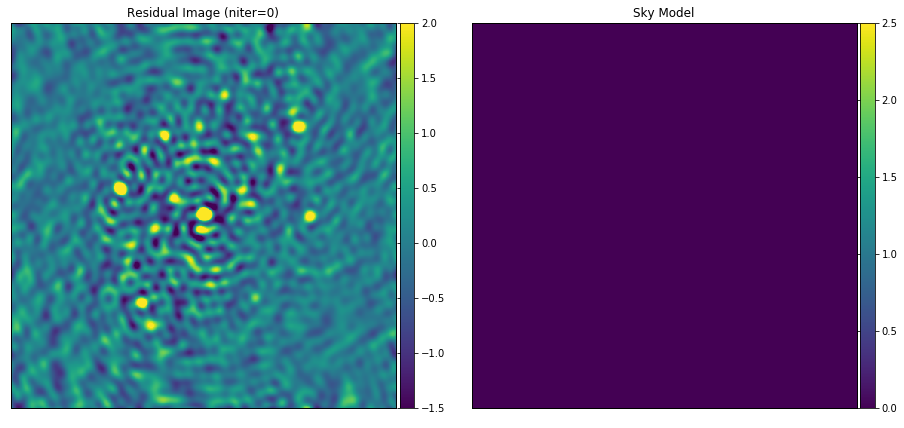

In [21]:
plotDeconvModelResidual(0)

图：初始残图和空的天空模型。

*Figure: intial residual image is initialized as the dirty image, the initial sky model is empty.*

在第一次迭代里，我们首先找到图像中的峰值流量（见下图，在图像的中央位置），然后把PSF移动到该峰值流量的位置，从残图中减掉PSF（根据峰值流量和增益值调整过的PSF），最后在天空模型里的峰值流量的位置增加一个delta函数（也是根据峰值流量和增益调整过）。注意，为了好看，下图中我们已经对天空模型卷积了一个理想PSF。经过一次迭代，残图看上去没什么变化，因为一次迭代只去掉了一个源的一小点流量，我们能在天空模型里看到该源。

The first iteration finds the peak flux to be from the source in the centre of the image (see figure below). The PSF, centred on that position, is subtracted (modulated by the flux and gain value) from the residual image. A delta function in that position, with that flux is added to the sky model. Note, we have convolved the sky models below with the ideal PSF for visualization purposes. The residual image looks unchanged after one iteration as only a small amount of flux was removed from a single source. We can see that source in the updated sky model.

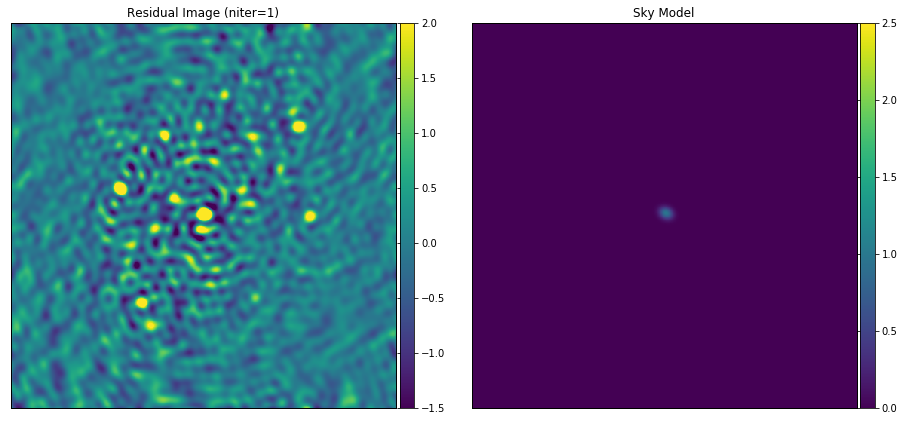

In [8]:
plotDeconvModelResidual(1)

图：一次迭代后的残图和天空模型。中央的源最亮，其部分流量被转移到了天空模型中，残图看上去几乎没有什么变化。

*Figure: residual image and sky model after one iteration of CLEAN. The central source is the brightest, so a portion of that flux was transfered to the sky model leaving the residual image relatively unchanged.*

经过10次迭代，位于残图中央的亮源的大部分流量被转移到了天空模型里，且旁瓣水平降低。但是，在残图里仍然能看到中央的这个亮源，同时，在天空模型中出现了第二个源，因为现在这个源成为了残图中的最亮的源。

Going forward to 10 iteration we see that a significant portion of the central source has been removed from the residual image and the sidelobe beating is a bit lower. But, the central source is still present in the residual image. In the sky model a second source has also been partially deconvolved because it is now the brightest source in the residual image.

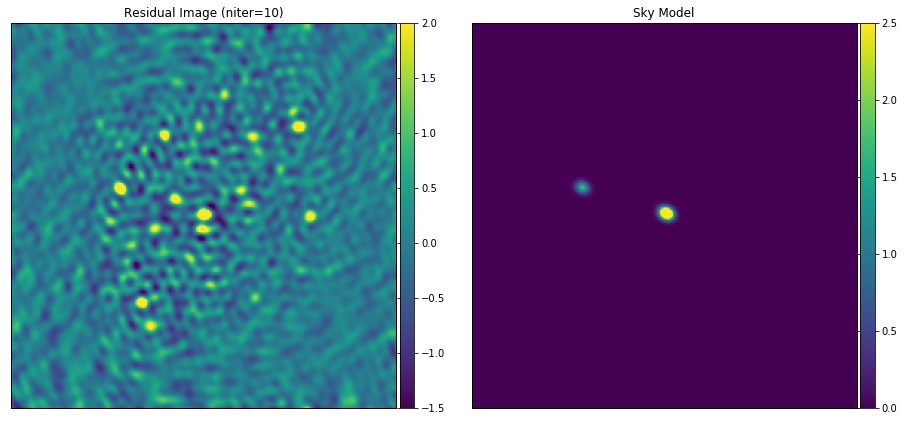

In [9]:
plotDeconvModelResidual(10)

图：经过10次CLEAN迭代后的残图和天空模型，天空模型中出现了第二个源。

*Figure: residual image and sky model after 10 iterations of CLEAN. A second source is partially deconvoled and added to the sky model.*

经过100次迭代后，残图中的许多源失去了流量，而天空模型中出现了多个源。虽然残图中还有剩余流量，但是，随着距离噪声水平越来越近，进一步去卷积有可能会把噪声也加入到天空模型。

Going forward to 100 iterations we can see that many of the sources in the residual image are reduced in flux while in the sky model there are multiple sources. There is still flux left in the residual image which can be deconvolved but as we get closer to the noise floor the deconvolution process has the potential to start adding noise to the sky model.

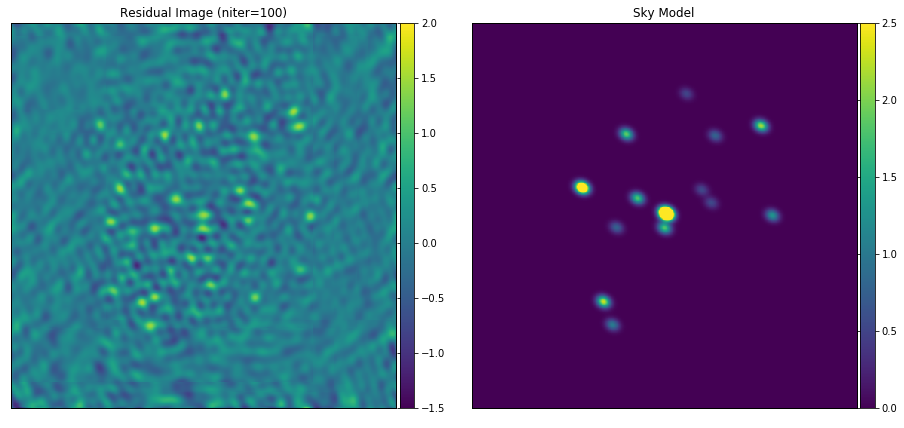

In [10]:
plotDeconvModelResidual(100)

图：100次CLEAN迭代后的残图和天空模型。残图中少了源而天空模型中多了源，虽然残图中还有流量，但是峰值已经接近图像的噪声水平。

*Figure: residual image and sky model after 100 iterations of CLEAN. Multiple sources have been deconvolved and added to the sky model, flux still remains in the residual image but the peak values re approaching the noise level of the image*

经过300次迭代以后，残图中基本只剩下噪声，剩余流量已经十分接近噪声水平，不适合继续处理下去。我们得到了最后的天空模型，其中包含了多个点源。

After 300 iterations the residual image is essentially noise, there is some remaining flux in the image but it is too close to the noise level to be deconvolved. The sky model now contains the final sky model with multiple point sources.

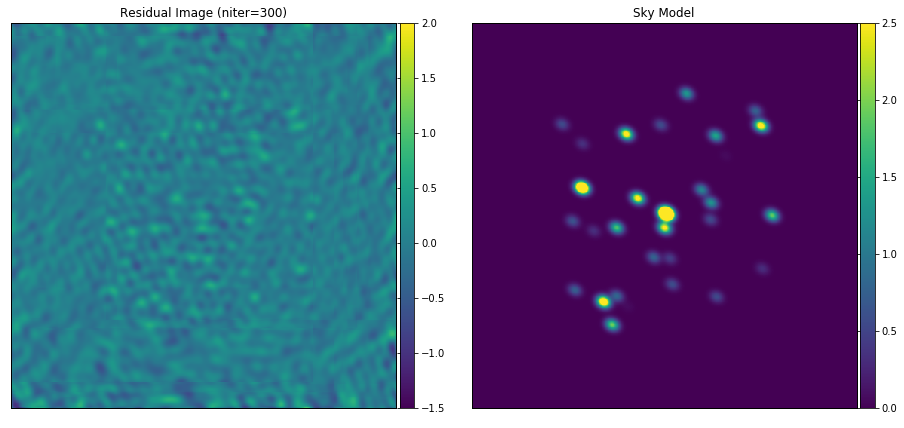

In [11]:
plotDeconvModelResidual(300)

图：300次迭代后的残图和天空模型。残图里剩下的几乎都是噪声，此时必须停止去卷积处理。最后的天空模型显示在右图中。

*Figure: residual image and sky model after 300 iterations. The residual image is close to noise-like and deconvolution must be halted, the final sky model is shown on the right.*

通过观察复原图和复原可见度，我们从另一个角度来研究去卷积过程。首先按照观测的uv轨迹进行采样得到可见度以及带有旁瓣的观测PSF，然后去卷积得到一张复原图，利用理想PSF，可见度平面上的采样区域得到了扩充。高斯函数的傅立叶变换仍然是一个高斯函数，因此我们的理想PSF在可见度域也是高斯分布。

We can look at the deconvolution process a little differently by looking at the restored image and the restored visibilities after a number of iterations. We start with visibilities which are sampled at the uv tracks of the observation which leads to an observed PSF with sidelobes. By deconvolving the creating a restored image, with an ideal PSF, we are effectively filling in the unsampled regions of the visibility plane. Remember, the Fourier transform of a Gaussian is also a Gaussian, so our ideal PSF will result in a Gaussian distribution in the visibility domain.

经过几次去卷积迭代，复原图看上去跟脏图差不多，可见度域里的uv轨迹也很清晰。

After only a few iterations of deconvolution (see figure below) the restored image looks similar to the dirty image and the $uv$ tracks are clear in the visibilities.

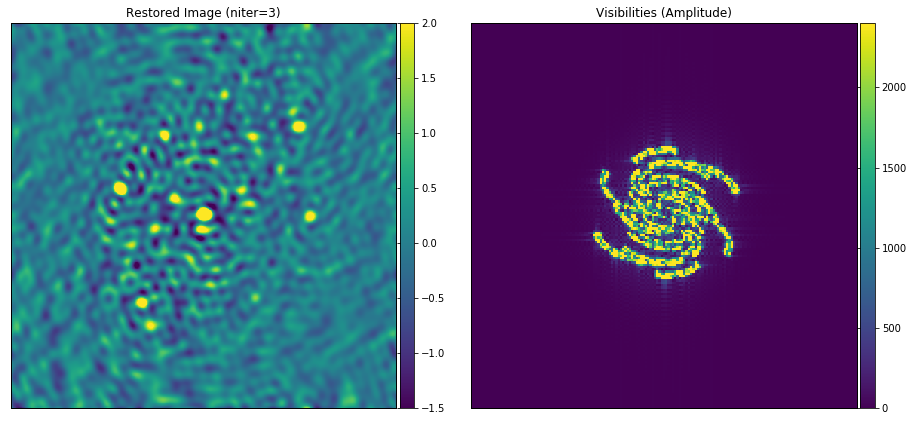

In [12]:
plotDeconvRestored(3)

图：经过三次CLEAN迭代处理后的复原图和可见度。复原图看上去跟脏图差不多，可见度里的uv轨迹很清楚。

*Figure: restored image and visibilities after three iterations of CLEAN. The restored image looks similar to the dirty image and the uv tracks are clear in the visibilities.*

经过30次迭代后，复原图里的PSF的旁瓣结构变弱，可见度图上的uv轨迹仍然明显，但是，已经能朦胧看到来自不同源的弱高斯功率谱，来自左边的第二个亮源所产生的条纹已经超出了uv轨迹的范围。

After 30 iterations there is reduced PSF sidelobe structure in the restored image. In the visibilities the uv tracks are still apparent, but there is a low amplitude Gaussian 'haze' from the different sources. There is a beating in the visibilities because the second brightest source is to the left of the centre creating a fringe.

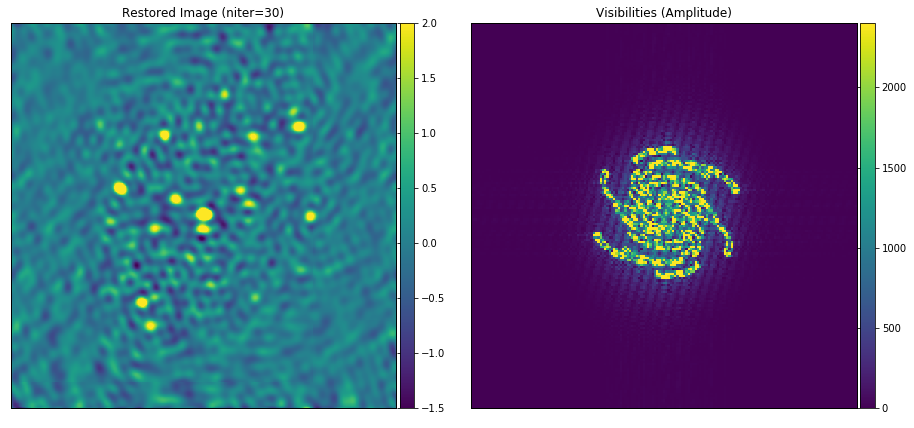

In [13]:
plotDeconvRestored(30)

图：经过30次CLEAN迭代的复原图和可见度。复原图中的旁瓣减弱，在右图里，uv轨迹范围以外也有了采样。

*Figure: restored image and visibilities after 30 iterations of CLEAN. Many of the sidelobes in the restored image are lower and the visibilities are sampled outside of the $uv$ tracks.*

在经过300次迭代处理后得到的复原图上，旁瓣已经不明显，总体效果相当不错。在右边的可见度图上，外缘的uv轨迹依然有点明显，但大部分都淹没在采样里。因为我们选择了高斯函数做为理想PSF，所以可见度功率谱由中间向周围逐渐减弱，这正是外缘的uv轨迹依然明显的原因。

In the final deconvolution of 300 iterations the restored image has not apparent sidelobes and looks fairly good. The uv tracks in the visibilities are still some what apparent, mostly near the edge, but for the most part buried in the sampling. Because we selected a Gaussian as the ideal PSF we should expect the visibility amplitudes to decrease away from the centre, this is why the uv track are still apparent near the edge.

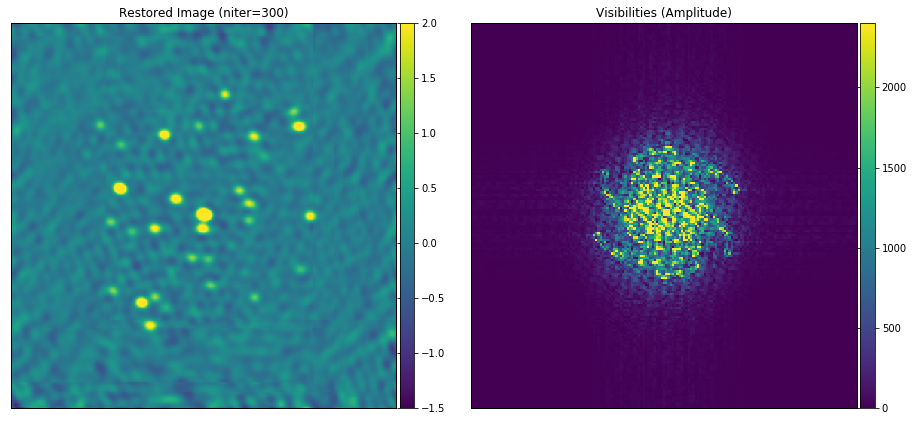

In [14]:
plotDeconvRestored(300)

图：300次CLEAN迭代的复原图和可见度。复原图中旁瓣不明显，可见度采样良好。

*Figure: restored image and visibilities after 300 iterations of CLEAN. There are no visible sidelobes in the restored image and the visibilities are well sampled.*

CLEAN的要点在于，通过迭代预测的方法对未被采样的可见度进行填充。因为我们不可能做到对整个可见度域的完全采样，所以我们不知道这种预测的实际效果到底有多好，而只是在各种可能的解决方案中选择了其中的一种。但是，CLEAN是基于点源假设的，在很多情况下效果不错，但也有近似效果不好的时候。

An important point to make here is that `CLEAN` is filling in the unsampled visibilities by an iterative guessing approach. Because the we have not sampled all the visibility domain we do not know how good this guess is. In fact, we are only selecting one of a set of infinite possible solutions. But, the solution is based on the decent approximation that the sources in our observation are all point sources. This is a pretty good approximation a lot of the time, but not always.

### 6.3.6 CLEAN的局限性以及现代去卷积的发展 Limits of CLEAN and Modern Deconvolution Developments

再次重申，迭代去卷积并不完美，不存在通用的完美的去卷积方法。但是，在多数情况下，迭代去卷积是一种良好的近似解决方案。随着计算能力的提升以及对更好的成像方法的需求推动，去卷积方法也取得了很多进展。

It is important to reiterate that iterative deconvolution is not perfect, unfortunately there is not general-purpose, perfect deconvolution method. But, iterative deconvolution is a good approximation most of the time. With the improvement in computing and the push towards better imaging there are a number of ongoing developments in deconvolution.

#### 多频率 Multiple Frequencies

我们已经解释过多频率问题，在[$\S$ 5.2 &#10142;](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb)讨论了通过观测带宽提高uv覆盖的方法。但是，这只适用于谱指数平坦的源（不可能存在）或者观测带宽窄到可以把这些源的谱指数视为平坦的情况。更好的近似方案为，在去卷积的时候综合考虑每个源的流量和谱指数，而不仅仅只考虑流量一个参数，这个过程被称为多频率合成 [<cite data-cite='2011A&A...532A..71R'>multi-frequency synthesis</cite> &#10548;](http://arxiv.org/abs/1106.2745)。

We have glossed over the issue of multiple frequencies. We have discussed how an increase in observing bandwidth leads to a improved *uv* coverage in [$\S$ 5.2 &#10142;](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb). But, this is only true for sources which have flat spectral indicies, which never occurs. But, this is a good approximation when the bandwidth is narrow enough such that sources can be treated as flat spectrum. This can work well in many cases, but for wide bandwidth observations this approximation breaks down. A better approximation is to treat each source as having a flux and spectral index parameter (instead of just a flux parameter) which are determined during deconvolution, this process is called [<cite data-cite='2011A&A...532A..71R'>multi-frequency synthesis</cite> &#10548;](http://arxiv.org/abs/1106.2745).

#### 宽场近似 Widefield Approximation

根据van Cittert-Zernike理论可知，可见度域和图像域之间的傅立叶关系只有在小角度近似的情况下才成立。但是我们可以通过消耗更多的计算能力对w项进行改正，从而提高这种近似，参见[$\S$ 5.5 &#10142;](../5_Imaging/5_5_widefield_effect.ipynb)，现在很多的成像工具和去卷积算法都默认带有w项改正。CLEAN的局限性在于，在次循环里用到的PSF都是指向相位中心的PSF，而事实上，PSF会随着方向发生改变，因此，在对远离相位中心的源去卷积时应该使用不同的PSF，否则就会导致一个点源被分成了多个。针对这一问题的解决方法是facet成像和3-D傅立叶变换，参考 [<cite data-cite='1992A&A...261..353C'>Radio-interferometric imaging of very large fields - The problem of non-coplanar arrays</cite> &#10548;](http://adsabs.harvard.edu/abs/1992A&A...261..353C)。

From the  van Cittert-Zernike theorem we kow the visibility-image domain Fourier relation only holds for the small angle approximation. We can correct for this by using more computing power to improve the approximation with w-term correction, see [$\S$ 5.5 &#10142;](../5_Imaging/5_5_widefield_effect.ipynb). Many modern imagers and deconvolution algorithms include w-term correction options by default. But, a limitation of `CLEAN` is that the PSF that is used during the minor cycle is the PSF for the array pointing at the phase centre. In fact, the PSF changes depending on direction, so sources far from the phase centre will have been convolved with a different PSF response compared to the deconvolving PSF. This leads to poor deconvolution results with a point source being spread out into different components at slightly different positions. See [<cite data-cite='1992A&A...261..353C'>Radio-interferometric imaging of very large fields - The problem of non-coplanar arrays</cite> &#10548;](http://adsabs.harvard.edu/abs/1992A&A...261..353C) for solutions using facet imaging and 3-D Fourier transforms.

#### 扩展源 Extended Sources

到目前为止，我们还没有深入讨论扩展源的去卷积问题。扩展源的去卷积问题比较复杂，具有很大挑战性。描述扩展源的参数很多，很难找到一个通用的描述方法。在点源去卷积方法的基础上，扩展出了多尺度去卷积方法multi-scale CLEAN[<cite data-cite='2011A&A...532A..71R'>multi-scale CLEAN</cite> &#10548;](http://arxiv.org/abs/1106.2745)。multi-scale CLEAN在$\delta$-fuction的基础上引入了高斯函数，因此可以用不同尺度的高斯函数来对任何源建模。

We have not discussed deconvolution of extended sources in depth. This is a coplex topic and one of the main challenges in developing modern deconvolution algorithms. Extended sources greatly open up the parameter space and are difficult to work with in a geenric way. An expansion of the point-source based deconvolution method has been [<cite data-cite='2011A&A...532A..71R'>multi-scale CLEAN</cite> &#10548;](http://arxiv.org/abs/1106.2745) which  introduces a Gaussian basis set along with the $\delta$-fuction basis set which is used to model any source with Gaussians of different size scales.

另一种去卷积的方法是采用压缩感知技术，比如基于小波去卷积 ([<cite data-cite='2015A&A...576A...7D'>MORESANE</cite> &#10548;](http://arxiv.org/abs/1412.5387))。

Another approach has been to take advantage of developments in compressed sensing to perform deconvolution in different basis domains, such as wavelet-based deconvoltion ([<cite data-cite='2015A&A...576A...7D'>MORESANE</cite> &#10548;](http://arxiv.org/abs/1412.5387)).

#### 模型选择 Model Selection

在观测可见度的基础上通过贝叶斯推理建立概率模型([<cite data-cite='2015MNRAS.450.1308L'>BIRO</cite> &#10548;](http://arxiv.org/abs/1501.05304))是一项很有意思的研究工作。因为去卷积只是一个近似处理的中间步骤，不是必须的，所以模型选择的方法不进行去卷积处理，而是直接在可见度数据的基础上建立各种不同的概率模型。

An interesting research focus has been on Bayesian model selection ([<cite data-cite='2015MNRAS.450.1308L'>BIRO</cite> &#10548;](http://arxiv.org/abs/1501.05304)) which attempts to avoid deconvolution by determining a probabilistic model based on the observed visibilities. The idea here is that deconvolution is an approximate, intermediate step which can be avoided. Further, by avoiding deconvolution a probability can be set on different models. 

#### 成像和去卷积算法 Imaging and Deconvolution algorithms

有很多通用的成像和去卷积算法的实现：

* [CASA clean &#10548;](https://casa.nrao.edu/docs/TaskRef/clean-task.html) : NRAO的CASA软件包里的成像和去卷积工具，包括了所有功能特性。
* [lwimager &#10548;](https://github.com/casacore/casarest) : 轻量级的成像和去卷积工具，稳定，但是没有新特性。
* [wsclean &#10548;](https://sourceforge.net/projects/wsclean/) : 通用宽视场成像和去卷积工具。

There are many implementations of imaging and deconvolution algorithms (often combined into one package), some generic, usable ones are:

* [CASA clean &#10548;](https://casa.nrao.edu/docs/TaskRef/clean-task.html) : full-featured imager and deconvolver included in NRAO's CASA package.
* [lwimager &#10548;](https://github.com/casacore/casarest) : light-weight imager and deconvolver, stable but new features are not being added.
* [wsclean &#10548;](https://sourceforge.net/projects/wsclean/) : generic widefield imager and deconvolver.

当我们说到“CLEAN”的时候，泛指一系列的迭代去卷积方法，而不单指某一个。在最原始的CLEAN方法的基础上扩展出了很多方法，广泛应用于当前的综合成像。到目前为止，我们还未讨论过什么时候应该停止去卷积，如何知道我们已经最大程度地去卷积？这些问题都一言难尽，我们将在下一节进行解释。

When we talk about `clean` we mean a class of various iterative deconvolution methods, not just a single method. There are various modifications and extension of the original `clean` methods which are now used regularly in synthesis imaging. One topic we have not discussed so far is when do we decide to halt the deconvolution process and how do we know we have maximized the amount of deconvolution possible? These are difficult questions to answer,  we will discuss why this is so in the next section.

***

Next: [6.4 Residuals and Image Quality](6_4_residuals_and_iqa.ipynb)

<div class=warn><b>Future Additions:</b></div>

* example: CLEAN implementation limits: hogbom deconvolution region, clark/hogbom aliasing and regions, compare three methods
* CLEAN relation to compressed sensing/matching pursuit
* expand MFS discussion, see https://casa.nrao.edu/Release3.3.0/docs/UserMan/UserMansu232.html
* limitations: extended source example
* example: changing the gain factor